Data Link : https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction?resource=download

In [1]:
import pandas as pd 
import numpy as np 
from datetime import datetime, timedelta
import yfinance as yf 
from textblob import TextBlob 
import re 
import matplotlib.pyplot as plt 
%matplotlib inline
from talib import EMA, RSI, OBV 
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn import metrics, tree
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore') 

In [2]:
data = pd.read_csv('stock_tweets.csv') 
data.head() 

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [3]:
data.tail() 

,Date,Tweet,Stock Name,Company Name
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.
80792,2021-09-30 10:22:52+00:00,Why can XPeng P5 deliver outstanding performan...,XPEV,XPeng Inc.


In [4]:
tsla_df = data[data['Stock Name']=='TSLA'] 
tsla_df.head() 

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [5]:
tsla_df = tsla_df.drop(columns=['Stock Name','Company Name']) 
tsla_df.head() 

,Date,Tweet
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,..."


In [6]:
print('First date : ',tsla_df['Date'].min())
print('Last date : ',tsla_df['Date'].max()) 

First date :  2021-09-30 01:16:13+00:00
Last date :  2022-09-29 23:41:16+00:00


In [7]:
tsla_df['Date'] = pd.to_datetime(tsla_df['Date']) 

### Clearing Tweets and Getting Sentiment

In [8]:
tsla_df['Clean_tweets'] = tsla_df['Tweet'].apply(lambda row: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",row).split())) 

In [9]:
tsla_df.head() 

,Date,Tweet,Clean_tweets
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,Mainstream media has done an amazing job at br...
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,Tesla delivery estimates are at around 364k fr...
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,3 Even if I include 63 0M unvested RSUs as of ...
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,Hahaha why are you still trying to stop Tesla ...
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",Stop trying to kill kids you sad deranged old man


In [10]:
tsla_df['tweet_sentiment'] = tsla_df['Clean_tweets'].apply(lambda row: 1 if TextBlob(row).sentiment.polarity>0 else (0 if TextBlob(row).sentiment.polarity==0 else -1))

In [11]:
tsla_df.head() 

,Date,Tweet,Clean_tweets,tweet_sentiment
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,Mainstream media has done an amazing job at br...,1
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,Tesla delivery estimates are at around 364k fr...,0
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,3 Even if I include 63 0M unvested RSUs as of ...,1
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,Hahaha why are you still trying to stop Tesla ...,1
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",Stop trying to kill kids you sad deranged old man,-1


Converting Date Column as DatetimeIndex 

In [12]:
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])
tsla_df.set_index('Date', inplace=True)

In [13]:
tweets_indicator_df =tsla_df.resample('D').tweet_sentiment.mean()

In [14]:
tweets_indicator_df.head() 

Date
2021-09-30 00:00:00+00:00    0.400000
2021-10-01 00:00:00+00:00    0.276596
2021-10-02 00:00:00+00:00    0.362069
2021-10-03 00:00:00+00:00    0.442623
2021-10-04 00:00:00+00:00    0.218487
Freq: D, Name: tweet_sentiment, dtype: float64

In [15]:
tweets_indicator_df.tail() 

Date
2022-09-25 00:00:00+00:00    0.527778
2022-09-26 00:00:00+00:00    0.430556
2022-09-27 00:00:00+00:00    0.294118
2022-09-28 00:00:00+00:00    0.373333
2022-09-29 00:00:00+00:00    0.294643
Freq: D, Name: tweet_sentiment, dtype: float64

### Cleaning Date column to remove time part 

In [16]:
tweets_indicator_df=tweets_indicator_df.tz_localize(None)

In [17]:
tweets_indicator_df.head() 

Date
2021-09-30    0.400000
2021-10-01    0.276596
2021-10-02    0.362069
2021-10-03    0.442623
2021-10-04    0.218487
Name: tweet_sentiment, dtype: float64

In [18]:
tweets_indicator_df.shape 

(365,)

In [19]:
tweets_indicator_df.fillna(method='ffill').head() 

Date
2021-09-30    0.400000
2021-10-01    0.276596
2021-10-02    0.362069
2021-10-03    0.442623
2021-10-04    0.218487
Name: tweet_sentiment, dtype: float64

In [20]:
type(tweets_indicator_df ) 

pandas.core.series.Series

### Getting close value of TSLA from 2021-09-30 to 2022-09-29    

In [21]:
def nxt_date(date):
    # Convert string to datetime object
    date = datetime.strptime(date, '%Y-%m-%d')

    # Calculate next date
    next_date = date + timedelta(days=1)

    # Convert next_date back to string format
    next_date_str = next_date.strftime('%Y-%m-%d')

    print(f"Next date after {date}: {next_date_str}") 
    return next_date_str 

In [22]:
ticker = 'TSLA'
start_date = '2021-09-30'   
end_date = '2022-09-29'
start_date_nxt = nxt_date(start_date)
end_date_nxt = nxt_date(end_date)     

Next date after 2021-09-30 00:00:00: 2021-10-01
Next date after 2022-09-29 00:00:00: 2022-09-30


In [23]:
#Retrieving historical Data

tsla_data = yf.download(ticker,start=start_date,end=end_date)
tsla_data_nxt = yf.download(ticker,start=start_date_nxt,end=end_date_nxt)  

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [24]:
tsla_data.head() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400


In [25]:
type(tsla_data)

pandas.core.frame.DataFrame

In [26]:
tsla_data.reset_index('Date',inplace=True) 
tsla_data_nxt.reset_index('Date',inplace=True)  

In [27]:
tsla_data['Close_nxt'] = tsla_data_nxt['Close']

In [28]:
tsla_data.head() 

,Date,Open,High,Low,Close,Adj Close,Volume,Close_nxt
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,258.406677
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,260.510010
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,260.196655
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,260.916656
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,264.536682


In [29]:
tsla_data['Date'] = pd.to_datetime(tsla_data['Date']) 
tsla_data.set_index('Date',inplace=True)  

In [30]:
tsla_data.head() 

,Open,High,Low,Close,Adj Close,Volume,Close_nxt
Date,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,258.406677
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,260.510010
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,260.196655
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,260.916656
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,264.536682


#### Calculating indicators using Talib library

In [31]:
ema_short_period = 10
ema_long_period = 30
rsi_period = 14

In [32]:
close_prices = np.array(tsla_data['Close']) 
volume_amnt = np.array(tsla_data['Volume']) 

In [33]:
tsla_data['ema_short'] = EMA(close_prices, timeperiod=ema_short_period)  
tsla_data['ema_long'] = EMA(close_prices, timeperiod=ema_long_period) 
tsla_data['rsi'] = RSI(close_prices, timeperiod=rsi_period) 

In [34]:
tsla_data.head() 

,Open,High,Low,Close,Adj Close,Volume,Close_nxt,ema_short,ema_long,rsi
Date,,,,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,258.406677,NaN,NaN,NaN
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,260.510010,NaN,NaN,NaN
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,260.196655,NaN,NaN,NaN
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,260.916656,NaN,NaN,NaN
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,264.536682,NaN,NaN,NaN


In [35]:
close_prices_obv = np.array(tsla_data['Close'], dtype=np.float64) 
volume_amnt_obv = np.array(tsla_data['Volume'], dtype=np.float64) 

In [36]:
tsla_data['obv'] = OBV(close_prices_obv, volume_amnt_obv) 

In [37]:
tsla_data.head() 

,Open,High,Low,Close,Adj Close,Volume,Close_nxt,ema_short,ema_long,rsi,obv
Date,,,,,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,258.406677,NaN,NaN,NaN,53868000.0
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,260.510010,NaN,NaN,NaN,2773800.0
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,260.196655,NaN,NaN,NaN,94223700.0
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,260.916656,NaN,NaN,NaN,38925900.0
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,264.536682,NaN,NaN,NaN,82824300.0


In [38]:
tsla_data.shape 

(251, 11)

In [39]:
tsla_data = tsla_data.dropna()
tsla_data.head() 

,Open,High,Low,Close,Adj Close,Volume,Close_nxt,ema_short,ema_long,rsi,obv
Date,,,,,,,,,,,
2021-11-10,336.803345,359.366669,329.103333,355.983337,355.983337,128408100,354.503326,368.989967,316.907224,57.032200,854557200.0
2021-11-11,367.589996,368.323334,351.559998,354.503326,354.503326,67189800,344.473328,366.356032,319.332779,56.499798,787367400.0
2021-11-12,349.166656,351.500000,339.733337,344.473328,344.473328,76719300,337.796661,362.377358,320.954749,52.895984,710648100.0
2021-11-15,339.209991,343.993347,326.200012,337.796661,337.796661,104326800,351.576660,357.908141,322.041324,50.583047,606321300.0
2021-11-16,334.436676,352.399994,334.059998,351.576660,351.576660,79627200,363.003326,356.756963,323.946830,54.960385,685948500.0


In [40]:
tsla_data.shape

(222, 11)

In [41]:
# Check if index 0f tsla_data is continuous after dropna

expected_index = pd.date_range(start=tsla_data.index.min(), end=tsla_data.index.max())
is_continuous = tsla_data.index.equals(expected_index)

if is_continuous:
    print("Index is continuous.")
else:
    print("Index is not continuous.") 

Index is not continuous.


In [42]:
new_df = tweets_indicator_df.reset_index()
new_df.columns = ['Date', 'tweet_sentiment'] 

In [43]:
new_df.head()  

,Date,tweet_sentiment
0,2021-09-30,0.400000
1,2021-10-01,0.276596
2,2021-10-02,0.362069
3,2021-10-03,0.442623
4,2021-10-04,0.218487


In [44]:
tsla_data.head() 

,Open,High,Low,Close,Adj Close,Volume,Close_nxt,ema_short,ema_long,rsi,obv
Date,,,,,,,,,,,
2021-11-10,336.803345,359.366669,329.103333,355.983337,355.983337,128408100,354.503326,368.989967,316.907224,57.032200,854557200.0
2021-11-11,367.589996,368.323334,351.559998,354.503326,354.503326,67189800,344.473328,366.356032,319.332779,56.499798,787367400.0
2021-11-12,349.166656,351.500000,339.733337,344.473328,344.473328,76719300,337.796661,362.377358,320.954749,52.895984,710648100.0
2021-11-15,339.209991,343.993347,326.200012,337.796661,337.796661,104326800,351.576660,357.908141,322.041324,50.583047,606321300.0
2021-11-16,334.436676,352.399994,334.059998,351.576660,351.576660,79627200,363.003326,356.756963,323.946830,54.960385,685948500.0


In [45]:
merge1_df = pd.merge(tsla_data, new_df, on='Date', how='inner') 

In [46]:
merge1_df.head() 

,Date,Open,High,Low,Close,Adj Close,Volume,Close_nxt,ema_short,ema_long,rsi,obv,tweet_sentiment
0,2021-11-10,336.803345,359.366669,329.103333,355.983337,355.983337,128408100,354.503326,368.989967,316.907224,57.032200,854557200.0,0.264550
1,2021-11-11,367.589996,368.323334,351.559998,354.503326,354.503326,67189800,344.473328,366.356032,319.332779,56.499798,787367400.0,0.324503
2,2021-11-12,349.166656,351.500000,339.733337,344.473328,344.473328,76719300,337.796661,362.377358,320.954749,52.895984,710648100.0,0.372093
3,2021-11-15,339.209991,343.993347,326.200012,337.796661,337.796661,104326800,351.576660,357.908141,322.041324,50.583047,606321300.0,0.231788
4,2021-11-16,334.436676,352.399994,334.059998,351.576660,351.576660,79627200,363.003326,356.756963,323.946830,54.960385,685948500.0,0.317829


#### Final Dataframe with Date as Column

In [47]:
columns_order = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'ema_short', 'ema_long', 'rsi', 'obv', 'tweet_sentiment', 'Close_nxt']
tsla_final = merge1_df[columns_order] 

In [48]:
tsla_final.head() 

,Date,Open,High,Low,Close,Adj Close,Volume,ema_short,ema_long,rsi,obv,tweet_sentiment,Close_nxt
0,2021-11-10,336.803345,359.366669,329.103333,355.983337,355.983337,128408100,368.989967,316.907224,57.032200,854557200.0,0.264550,354.503326
1,2021-11-11,367.589996,368.323334,351.559998,354.503326,354.503326,67189800,366.356032,319.332779,56.499798,787367400.0,0.324503,344.473328
2,2021-11-12,349.166656,351.500000,339.733337,344.473328,344.473328,76719300,362.377358,320.954749,52.895984,710648100.0,0.372093,337.796661
3,2021-11-15,339.209991,343.993347,326.200012,337.796661,337.796661,104326800,357.908141,322.041324,50.583047,606321300.0,0.231788,351.576660
4,2021-11-16,334.436676,352.399994,334.059998,351.576660,351.576660,79627200,356.756963,323.946830,54.960385,685948500.0,0.317829,363.003326


In [49]:
tsla_final['Date'] = pd.to_datetime(tsla_final['Date']) 
tsla_final.set_index('Date',inplace=True)  

#### Final Dataframe with Date as Index

In [50]:
tsla_final.head() 

,Open,High,Low,Close,Adj Close,Volume,ema_short,ema_long,rsi,obv,tweet_sentiment,Close_nxt
Date,,,,,,,,,,,,
2021-11-10,336.803345,359.366669,329.103333,355.983337,355.983337,128408100,368.989967,316.907224,57.032200,854557200.0,0.264550,354.503326
2021-11-11,367.589996,368.323334,351.559998,354.503326,354.503326,67189800,366.356032,319.332779,56.499798,787367400.0,0.324503,344.473328
2021-11-12,349.166656,351.500000,339.733337,344.473328,344.473328,76719300,362.377358,320.954749,52.895984,710648100.0,0.372093,337.796661
2021-11-15,339.209991,343.993347,326.200012,337.796661,337.796661,104326800,357.908141,322.041324,50.583047,606321300.0,0.231788,351.576660
2021-11-16,334.436676,352.399994,334.059998,351.576660,351.576660,79627200,356.756963,323.946830,54.960385,685948500.0,0.317829,363.003326


### Choosing X and y values for model training

In [51]:
X = tsla_final.drop(columns=['Close_nxt']) 
y = tsla_final['Close_nxt']

In [52]:
X_cols = list(X.columns)
X_cols

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'ema_short',
 'ema_long',
 'rsi',
 'obv',
 'tweet_sentiment']

In [53]:
split_index = int(0.7 * tsla_final.shape[0]) 
print(tsla_final.shape[0], split_index) 

222 155


In [54]:
# Split the data
x_train, x_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:] 
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}") 

x_train shape: (155, 11)
x_test shape: (67, 11)
y_train shape: (155,)
y_test shape: (67,)


In [55]:
y_test.head() 

Date
2022-06-24    244.919998
2022-06-27    232.663330
2022-06-28    228.490005
2022-06-29    224.473328
2022-06-30    227.263336
Name: Close_nxt, dtype: float64

### x and y values from train set

In [56]:
x_test_copy = x_test.copy()
y_test_copy = y_test.copy() 

In [57]:
x_val = x_train.values 
y_val = y_train.values.ravel() 

In [58]:
y_val = np.round(y_val,4) 

In [59]:
sc = StandardScaler(copy=True, with_mean=True, with_std=True)

In [60]:
x_normal = np.round(sc.fit_transform(x_val),4)

In [61]:
x_normal

array([[ 5.9990e-01,  9.0960e-01,  6.5270e-01, ...,  1.0017e+00,
         6.8420e-01, -3.8660e-01],
       [ 1.2484e+00,  1.0990e+00,  1.1366e+00, ...,  9.4680e-01,
         3.9900e-01,  3.6650e-01],
       [ 8.6030e-01,  7.4320e-01,  8.8170e-01, ...,  5.7450e-01,
         7.3300e-02,  9.6430e-01],
       ...,
       [-1.7633e+00, -1.5389e+00, -1.6047e+00, ...,  8.7800e-02,
        -2.2940e-01,  1.6000e-03],
       [-1.5548e+00, -1.4700e+00, -1.4002e+00, ...,  5.3600e-02,
        -6.5860e-01,  1.3560e-01],
       [-1.4831e+00, -1.6290e+00, -1.5120e+00, ...,  1.4800e-02,
        -1.1009e+00, -2.0992e+00]])

#### Cross Validation

In [62]:
tss = TimeSeriesSplit(n_splits=5) 
print(tss) 

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


### Defining Random Forest Model

In [63]:
model = RandomForestRegressor(n_estimators=20, max_features='sqrt',
                              max_depth=10, random_state=42)

### Cross-validation and Metrics

In [64]:
model_score=[]
imp_of_predictors = []
mae = []
mse = []
rmse = [] 

In [65]:
for train_index, test_index in tss.split(x_val):
    x_train, x_test = x_val[train_index], x_val[test_index]
    y_train, y_test = y_val[train_index], y_val[test_index]
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test) 
    model_score.append(metrics.r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average'))
    imp_of_predictors.append(model.feature_importances_)
    mae.append(metrics.mean_absolute_error(y_test, y_pred))
    mse.append(metrics.mean_squared_error(y_test,y_pred))
    rmse.append(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('Model Score : ',model_score) 
print('Importance of predictors : ',imp_of_predictors)
print('Mean Absolute Error : ',mae)
print('Mean squared error : ',mse)
print('Root mean squared error : ',rmse) 

Model Score :  [0.6150558262686643, -2.6307143021699795, 0.8658247626627701, 0.5175935296795802, -3.9179868074327517]
Importance of predictors :  [array([0.08933969, 0.07682129, 0.07368651, 0.21609628, 0.13160572,
       0.02744398, 0.16361694, 0.04146583, 0.16278299, 0.01166921,
       0.00547156]), array([0.04246447, 0.05063886, 0.05899623, 0.31650042, 0.15552207,
       0.0497629 , 0.0279295 , 0.03776393, 0.17140695, 0.07005001,
       0.01896467]), array([0.08468881, 0.06896934, 0.05189103, 0.33693369, 0.1785037 ,
       0.02174137, 0.06386511, 0.03167851, 0.12898705, 0.02273625,
       0.01000514]), array([0.08019902, 0.07027598, 0.10082117, 0.3509857 , 0.18907328,
       0.01428751, 0.01321892, 0.018079  , 0.08819837, 0.06436827,
       0.01049278]), array([0.08308633, 0.07290898, 0.10139044, 0.34664134, 0.19137196,
       0.01693145, 0.09704169, 0.02250314, 0.04696425, 0.00995782,
       0.0112026 ])]
Mean Absolute Error :  [12.68949319999999, 25.35916559999997, 11.0481834500000

#### Checking for invalid values

In [66]:
np.isinf(y_test).sum(), np.isnan(y_test).sum() 

(0, 0)

In [67]:
y_test=pd.Series(y_test)
(y_test[np.isnan(y_test)]) 

Series([], dtype: float64)

### Comparing real and predicted values

In [68]:
len(y_test) 

25

In [69]:
points = range(y_test.shape[0])
points 

range(0, 25)

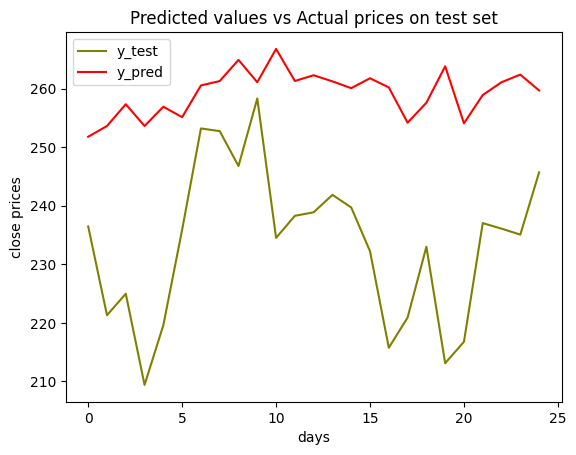

In [70]:
plt.plot(points, y_test, color='olive', label='y_test')
plt.plot(points, y_pred, color='red', label='y_pred')
plt.ylabel('close prices')
plt.xlabel('days') 
plt.title('Predicted values vs Actual prices on test set')
plt.legend(loc='upper left') 


#### Predicting values using x_test and creating signal

In [71]:
print(x_test_copy.shape) 
x_test_copy['price_prediction'] = model.predict(x_test_copy.loc[:,X_cols]) 

(67, 11)


In [72]:
x_test_copy['model_signal'] = np.where(x_test_copy['price_prediction']>x_test_copy['Close'],1,-1) 

### Defining Strategy and Compute the return

In [73]:
def compute_ret(df):
    df['ret'] = df.Close.shift(-1).pct_change()
    df['cum_ret'] = np.cumsum(df.ret)
    df['strategy_ret'] = df.ret * df.model_signal.shift(1)
    df['cum_strategy_ret'] = np.cumsum(df.strategy_ret)
    return df 

In [74]:
df2 = compute_ret(x_test_copy)

In [75]:
df2.head()

,Open,High,Low,Close,Adj Close,Volume,ema_short,ema_long,rsi,obv,tweet_sentiment,price_prediction,model_signal,ret,cum_ret,strategy_ret,cum_strategy_ret
Date,,,,,,,,,,,,,,,,,
2022-06-24,237.470001,246.066666,236.086670,245.706665,245.706665,95770800,233.665788,243.650488,51.749064,529807500.0,0.240741,263.233840,1,NaN,NaN,NaN,NaN
2022-06-27,249.366669,252.070007,242.566666,244.919998,244.919998,89178300,235.712008,243.732392,51.415963,440629200.0,0.391304,261.859510,1,-0.050044,-0.050044,-0.050044,-0.050044
2022-06-28,244.483337,249.970001,232.343338,232.663330,232.663330,90391200,235.157703,243.018259,46.404126,350238000.0,0.250000,261.191005,1,-0.017937,-0.067981,-0.017937,-0.067981
2022-06-29,230.500000,231.173340,222.273331,228.490005,228.490005,82897200,233.945394,242.080952,44.802734,267340800.0,0.350000,260.633835,1,-0.017579,-0.085560,-0.017579,-0.085560
2022-06-30,224.509995,229.456665,218.863327,224.473328,224.473328,94600500,232.223200,240.944976,43.255513,172740300.0,0.220779,261.843670,1,0.012429,-0.073131,0.012429,-0.073131


### Plot return of benchmark and strategy

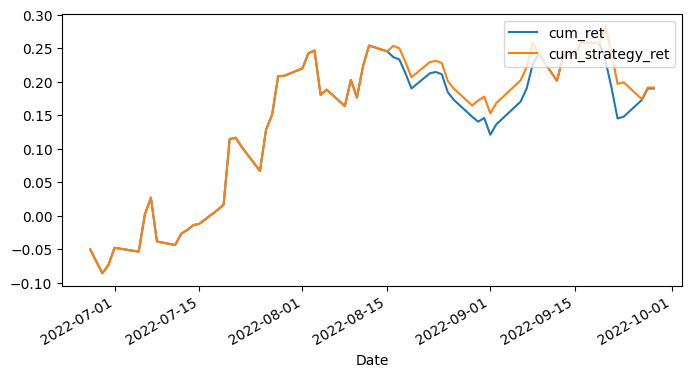

In [76]:
df2['cum_ret'].plot(figsize=(8,4))
df2['cum_strategy_ret'].plot(figsize=(8,4)) 
plt.legend(loc='upper right')
plt.show() 

#### Calculating Sharpe Ratio

In [77]:
def sharpe(df):
    sharpe_ratio = df.strategy_ret.mean()/df.strategy_ret.std()*np.sqrt(252)
    return sharpe_ratio

In [78]:
sharpe(df2) 

1.5454226455455782

In [79]:
print('Average cumulative return : ',df2['cum_ret'].mean())
print('Average strategic cumulative return : ',df2['cum_strategy_ret'].mean())

Average cumulative return :  0.13741628076801457
Average strategic cumulative return :  0.1465263961435433
